faydalı olabilecek kaynaklar.

https://arxiv.org/pdf/2106.06910.pdf

https://dergipark.org.tr/tr/download/article-file/2250513

https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/   vader sentiment analiz için kullanılabilir

# First Looking at the data

In [6]:
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


# Read CSV Files

In [18]:
data = pd.read_csv('/home/benjamin/Masaüstü/DS/tweet_analysis/PatientSafety/patient_safety2.csv', encoding='utf-8')

In [25]:
data.columns

Index(['User', 'Follows_Count', 'Friends_Count', 'Retweet_Count', 'Language', 'Date_Tweet', 'Number_of_Likes', 'Tweet_Id', 'Tweet', 'Hashtags', 'Coordinates', 'Place'], dtype='object')

In [21]:
data.shape

(249979, 12)

In [3]:
data.Tweet.duplicated().sum()

3509

In [23]:
data.Language.value_counts().nunique()

40

In [27]:
data.Language.value_counts()

en     240127
qme      1861
qht      1286
fr        980
es        833
und       831
pl        693
ar        554
in        475
de        459
ca        297
th        200
ja        152
pt        148
nl        147
it        141
tl        117
qam        87
da         80
hi         75
ro         70
fi         47
sv         45
ht         31
cy         28
el         19
tr         18
ta         16
no         15
ne         14
gu         14
mr         13
et         11
sl         10
fa          9
ru          8
ur          8
zh          8
kn          5
cs          5
qst         5
si          4
te          4
bn          4
ko          3
lt          3
zxx         3
vi          3
hu          2
bg          2
ml          2
am          2
lv          2
eu          1
iw          1
dv          1
Name: Language, dtype: int64

In [26]:
data.Place.value_counts().nunique()

53

In [4]:
data = data.drop_duplicates(subset=['Tweet'])

In [5]:
data.head()

,User,Follows_Count,Friends_Count,Retweet_Count,Language,Date_Tweet,Number_of_Likes,Tweet_Id,Tweet,Hashtags,Coordinates,Place
0,ZKusynova,557,193,0,en,2022-12-05 10:01:31+00:00,0,"1,59970551827612E+018","It is encouraging to see that the @WHO ""Global...",['patientsafety'],NaN,NaN
1,EllieGray6272,483,432,0,en,2022-12-05 10:00:44+00:00,0,"1,59970532305262E+018",@DocMCohen @DrAseemMalhotra Says the unethical...,['BigPharma'],NaN,NaN
2,ParamountB,329,816,0,en,2022-12-05 10:00:33+00:00,0,"1,59970527413848E+018","👉Shop now &amp; get 10% Discount: \n""FIRST AID...","['firstaid', 'cpr', 'firstaidtraining', 'emerg...",NaN,NaN
3,Ksehmi5,281,51,0,en,2022-12-05 09:54:06+00:00,0,"1,59970365237706E+018",@Mondher_Letaief ground breaking work been car...,"['patientsafety', 'GlobalPatientSafetyActionPl...","Coordinates(longitude=6.046126, latitude=46.21...","Place(fullName='Meyrin, Suisse', name='Meyrin'..."
4,7Sebe,696,1730,0,en,2022-12-05 09:52:32+00:00,2,"1,59970325797867E+018",Reality of today’s NHS approach to #patientsaf...,"['patientsafety', 'fullpayrestoration']",NaN,NaN


In [6]:
# sadece dili ingilizce olanlar
data = data[data['Language'] == 'en']
data.shape

(236955, 12)

In [8]:
columns_to_drop = ['Coordinates','Language', 'Place']
df = data.drop(columns_to_drop, axis=1)
df.columns = df.columns.str.lower()

In [9]:
df.head()

,user,follows_count,friends_count,retweet_count,date_tweet,number_of_likes,tweet_id,tweet,hashtags
0,ZKusynova,557,193,0,2022-12-05 10:01:31+00:00,0,"1,59970551827612E+018","It is encouraging to see that the @WHO ""Global...",['patientsafety']
1,EllieGray6272,483,432,0,2022-12-05 10:00:44+00:00,0,"1,59970532305262E+018",@DocMCohen @DrAseemMalhotra Says the unethical...,['BigPharma']
2,ParamountB,329,816,0,2022-12-05 10:00:33+00:00,0,"1,59970527413848E+018","👉Shop now &amp; get 10% Discount: \n""FIRST AID...","['firstaid', 'cpr', 'firstaidtraining', 'emerg..."
3,Ksehmi5,281,51,0,2022-12-05 09:54:06+00:00,0,"1,59970365237706E+018",@Mondher_Letaief ground breaking work been car...,"['patientsafety', 'GlobalPatientSafetyActionPl..."
4,7Sebe,696,1730,0,2022-12-05 09:52:32+00:00,2,"1,59970325797867E+018",Reality of today’s NHS approach to #patientsaf...,"['patientsafety', 'fullpayrestoration']"


# Metedoloji için Kullanılabilir

In [10]:
# kullanıcı sayısı ve tweet sayısı
print(f'{df.shape[0]} tweets from different {df.user.nunique()} unique users')

236955 tweets from different 71063 unique users


In [11]:
# # tweet sayısı ve kullanıcı sayısı oranları piechart  
# plt.figure(figsize=(10,10))
# plt.pie([df.user.nunique(), df.shape[0]], labels=['Unique Users', 'Tweets'], autopct='%1.1f%%', colors=['#ff9999','#66b3ff'],\
#  startangle=90, textprops={'fontsize': 14}, wedgeprops=dict(width=0.3), explode=(0.05,0), shadow=True, pctdistance=0.85,\
#     labeldistance=1.1, radius=1.2, counterclock=False, center=(0,0), frame=False)

# # users_tweets_rate = pd.DataFrame({'User Numbers': df.user.nunique(), 'Tweet Numbers': len(df)}, index = range(0,1))\
# #                                     .T[0].plot.pie(figsize=(6,6), autopct='%1.1f%%', fontsize=15, colors=['#ff9999','#66b3ff'],\
# #                                             wedgeprops=dict(width=0.3), startangle=90, explode=(0.05,0), legend=True)
# plt.legend(loc='center')
# plt.show()                                            

## yıl ay gün analizi

In [12]:
df.date_tweet = pd.to_datetime(df.date_tweet)
df['year']= df.date_tweet.dt.year
df['month'] = df.date_tweet.dt.month_name()    
df['day'] = df.date_tweet.dt.day_name()
df.head()

,user,follows_count,friends_count,retweet_count,date_tweet,number_of_likes,tweet_id,tweet,hashtags,year,month,day
0,ZKusynova,557,193,0,2022-12-05 10:01:31+00:00,0,"1,59970551827612E+018","It is encouraging to see that the @WHO ""Global...",['patientsafety'],2022,December,Monday
1,EllieGray6272,483,432,0,2022-12-05 10:00:44+00:00,0,"1,59970532305262E+018",@DocMCohen @DrAseemMalhotra Says the unethical...,['BigPharma'],2022,December,Monday
2,ParamountB,329,816,0,2022-12-05 10:00:33+00:00,0,"1,59970527413848E+018","👉Shop now &amp; get 10% Discount: \n""FIRST AID...","['firstaid', 'cpr', 'firstaidtraining', 'emerg...",2022,December,Monday
3,Ksehmi5,281,51,0,2022-12-05 09:54:06+00:00,0,"1,59970365237706E+018",@Mondher_Letaief ground breaking work been car...,"['patientsafety', 'GlobalPatientSafetyActionPl...",2022,December,Monday
4,7Sebe,696,1730,0,2022-12-05 09:52:32+00:00,2,"1,59970325797867E+018",Reality of today’s NHS approach to #patientsaf...,"['patientsafety', 'fullpayrestoration']",2022,December,Monday


In [38]:
df = df[df.year >= 2020]

In [28]:
df.groupby('year').count()['tweet']

year
2020    71487
2021    61715
2022    67728
Name: tweet, dtype: int64

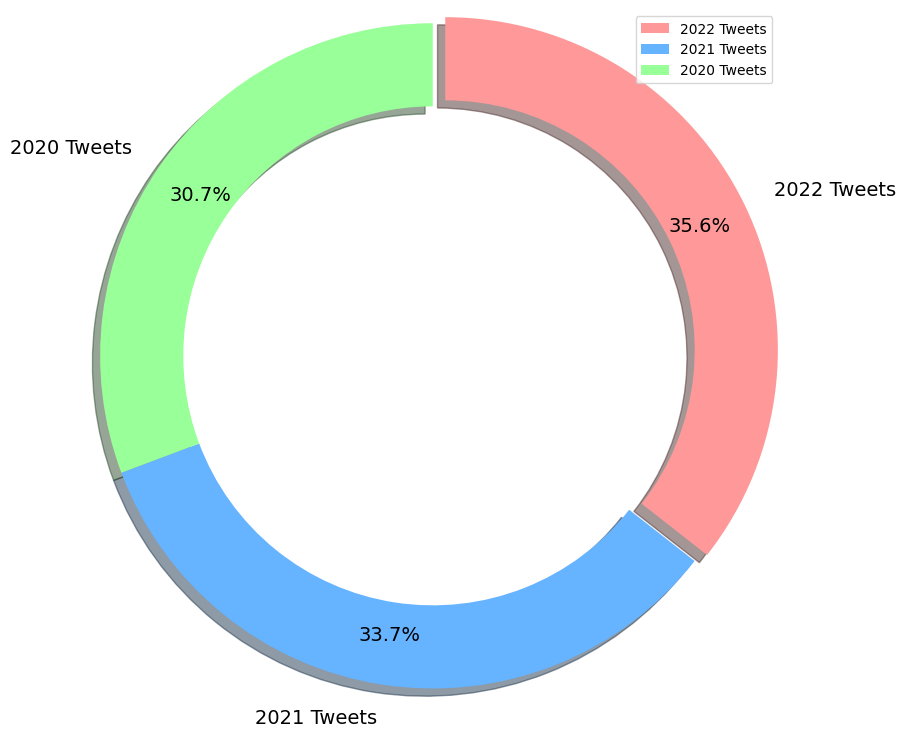

In [29]:
# Datada yer alan tweetlerin yıllara göre dağılımı
plt.figure(figsize=(9,9))
plt.pie(df.year.value_counts(), labels=['2022 Tweets', '2021 Tweets', '2020 Tweets'], autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99'],\
 startangle=90, textprops={'fontsize': 14}, wedgeprops=dict(width=0.3), explode=(0.05,0,0), shadow=True, pctdistance=0.85,\
    labeldistance=1.1, radius=1.2, counterclock=False, center=(0,0), frame=False)
plt.legend(loc='upper right')
plt.show()

([<matplotlib.patches.Wedge at 0x7ff3e2803eb0>,
 [Text(0.46270548740835626, 0.9979497141250133, '2020'),
  Text(-1.0842449638103997, -0.18550703073410754, '2022'),
  Text(0.6243752570356628, -0.9056243914568832, '2021')])

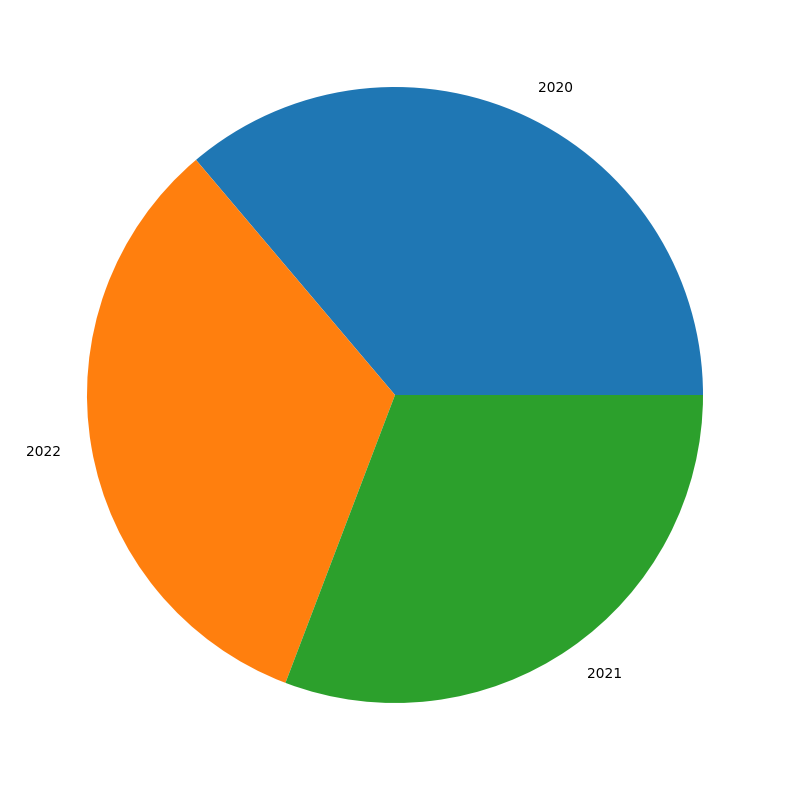

In [40]:
# Datada yer alan tweetlerin yıllara göre dağılımı

plt.figure(figsize=(10,10))
plt.pie(df['year'].value_counts(), labels=df['year'].value_counts().index)

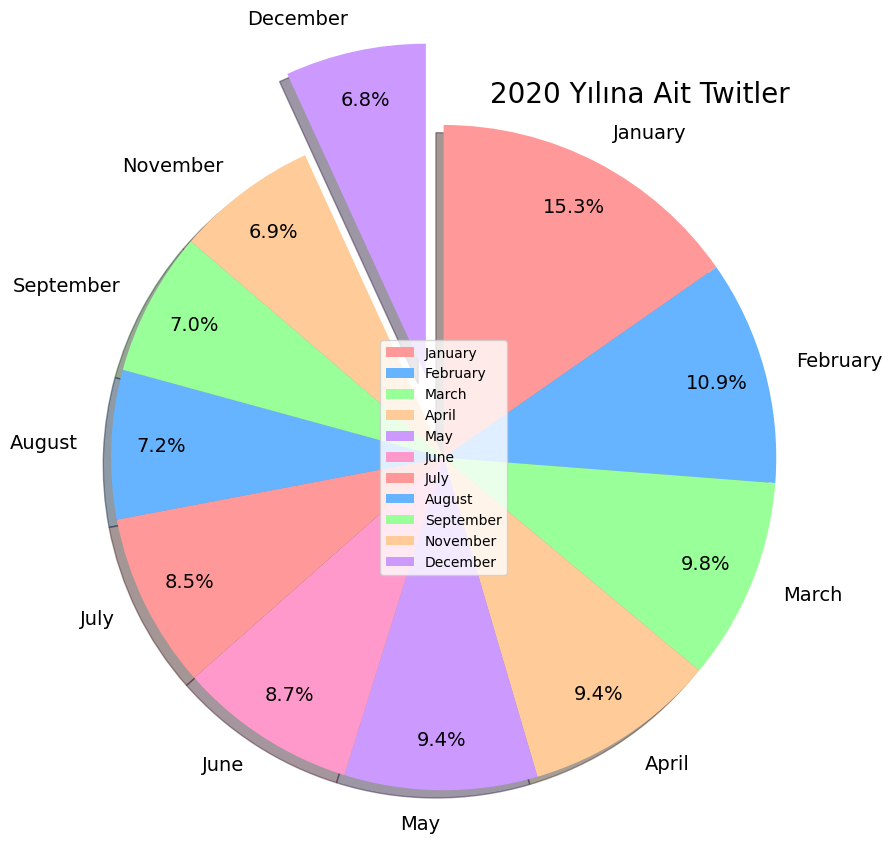

In [53]:
# tweetlerin aylara göre dağılımı
plt.figure(figsize=(9,9))
plt.pie(df[df['year']==2020].month.value_counts()[:11], labels=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'November', 'December'], autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99','#ffcc99','#cc99ff','#ff99cc','#ff9999','#66b3ff','#99ff99','#ffcc99','#cc99ff','#ff99cc'],\
    startangle=90, textprops={'fontsize': 14}, explode=(0.0,0,0,0,0,0,0,0,0.0,0.0,0.3), shadow=True, pctdistance=0.85,\
    labeldistance=1.1, radius=1.2, counterclock=False, center=(0,0), frame=False)
plt.legend(loc='center')
plt.title("2020 Yılına Ait Twitler", loc='right', fontsize=20)
plt.show()


# not eğer bu analizi fayfalı bulursan diğer yılları ekleyebiliriz

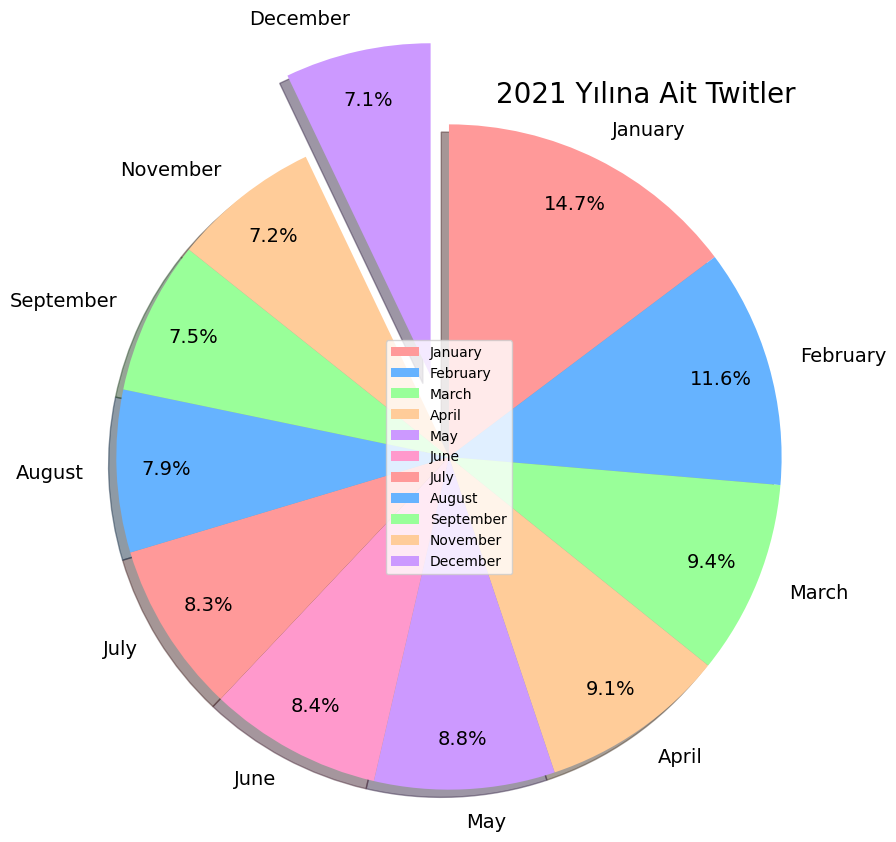

In [52]:
# tweetlerin aylara göre dağılımı
plt.figure(figsize=(9,9))
plt.pie(df[df['year']==2021].month.value_counts()[:11], labels=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'November', 'December'], autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99','#ffcc99','#cc99ff','#ff99cc','#ff9999','#66b3ff','#99ff99','#ffcc99','#cc99ff','#ff99cc'],\
    startangle=90, textprops={'fontsize': 14}, explode=(0.0,0,0,0,0,0,0,0,0.0,0.0,0.3), shadow=True, pctdistance=0.85,\
    labeldistance=1.1, radius=1.2, counterclock=False, center=(0,0), frame=False)
plt.legend(loc='center')
plt.title("2021 Yılına Ait Twitler", loc='right', fontsize=20)
plt.show()


# not eğer bu analizi fayfalı bulursan diğer yılları ekleyebiliriz

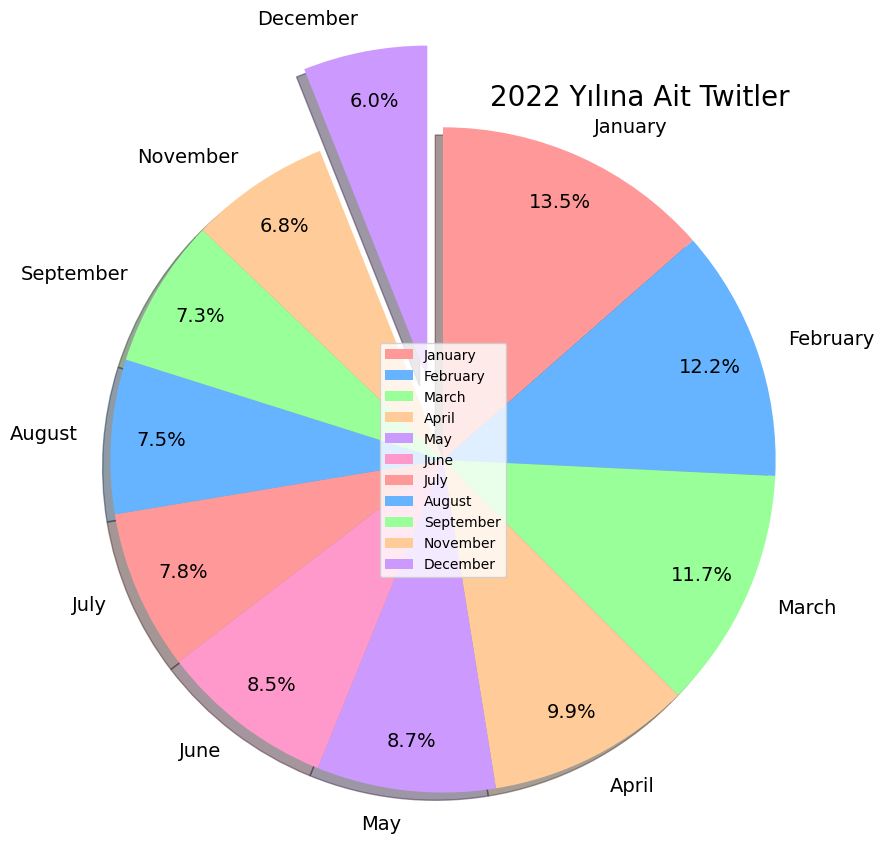

In [54]:
# tweetlerin aylara göre dağılımı
plt.figure(figsize=(9,9))
plt.pie(df[df['year']==2022].month.value_counts()[:11], labels=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'November', 'December'], autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99','#ffcc99','#cc99ff','#ff99cc','#ff9999','#66b3ff','#99ff99','#ffcc99','#cc99ff','#ff99cc'],\
    startangle=90, textprops={'fontsize': 14}, explode=(0.0,0,0,0,0,0,0,0,0.0,0.0,0.3), shadow=True, pctdistance=0.85,\
    labeldistance=1.1, radius=1.2, counterclock=False, center=(0,0), frame=False)
plt.legend(loc='center')
plt.title("2022 Yılına Ait Twitler", loc='right', fontsize=20)
plt.show()


# not eğer bu analizi fayfalı bulursan diğer yılları ekleyebiliriz

In [30]:
df.groupby('month').count()['tweet']

month
April        14025
August       14008
December      9419
February     14780
January      14935
July         15845
June         15461
March        20664
May          15306
November     19122
October      19575
September    27790
Name: tweet, dtype: int64

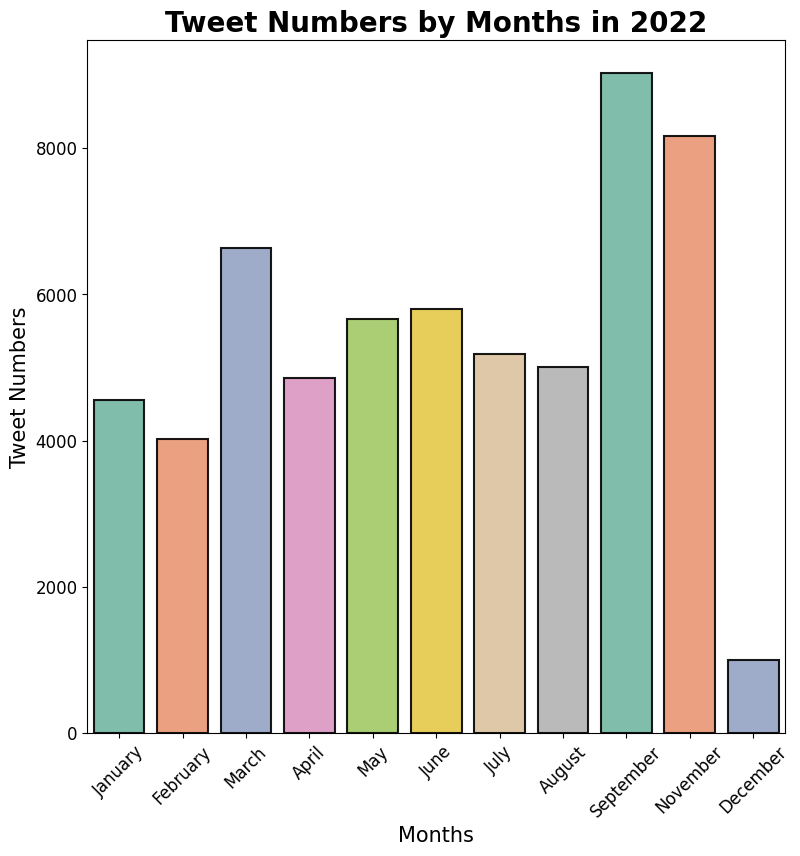

(<AxesSubplot: title={'center': 'Tweet Numbers by Months in 2022'}, xlabel='Months', ylabel='Tweet Numbers'>,
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
  [Text(0, 0, 'January'),
   Text(1, 0, 'February'),
   Text(2, 0, 'March'),
   Text(3, 0, 'April'),
   Text(4, 0, 'May'),
   Text(5, 0, 'June'),
   Text(6, 0, 'July'),
   Text(7, 0, 'August'),
   Text(8, 0, 'September'),
   Text(9, 0, 'November'),
   Text(10, 0, 'December')]),
 (array([    0.,  2000.,  4000.,  6000.,  8000., 10000.]),
  [Text(0, 0.0, '0'),
   Text(0, 2000.0, '2000'),
   Text(0, 4000.0, '4000'),
   Text(0, 6000.0, '6000'),
   Text(0, 8000.0, '8000'),
   Text(0, 10000.0, '10000')]),
 Text(0.5, 30.0, 'Months'),
 Text(30.0, 0.5, 'Tweet Numbers'),
 Text(0.5, 1.0, 'Tweet Numbers by Months in 2022'),
 None)

In [56]:

import seaborn as sns
plt.figure(figsize=(9,9))
sns.countplot(x='month', data=df[df['year']==2022], palette='Set2',\
    order=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'November', 'December'],\
        edgecolor='black', linewidth=1.5, saturation=0.75, alpha=0.9),\
             plt.xticks(rotation=45, fontsize=12), plt.yticks(fontsize=12),\
                    plt.xlabel('Months', fontsize=15), plt.ylabel('Tweet Numbers', fontsize=15),\
                        plt.title('Tweet Numbers by Months in 2022', fontsize=20, fontweight='bold'),\
plt.show()


# gerek görülürse diğer yıllar eklenebilir

In [19]:
df.head()

,user,date_created,follows_count,friends_count,retweet_count,date_tweet,number_of_likes,source_of_tweet,tweet_id,tweet,hashtags,year,month,day
0,palermino_susan,2015-12-03 15:25:58+00:00,1561,2678,0,2022-11-30 23:58:11+00:00,0.0,Twitter for Android,1.598104e+18,@elonmusk I thunk you're an irresponsible for ...,NaN,2022,November,Wednesday
1,JoshL1220,2011-09-09 20:37:36+00:00,1664,800,0,2022-11-30 23:57:10+00:00,4.0,Twitter for Android,1.598104e+18,"Apparently ""I've had COVID for over a week and...",NaN,2022,November,Wednesday
2,SierraMama55,2022-06-02 20:49:49+00:00,82,144,0,2022-11-30 23:54:03+00:00,1.0,Twitter for iPad,1.598103e+18,@snakewasright @EllenOl00313689 @iTruthSearch ...,NaN,2022,November,Wednesday
3,Monocerotos69,2020-02-27 02:05:36+00:00,46,455,0,2022-11-30 23:52:17+00:00,0.0,Twitter for iPhone,1.598103e+18,They're dropping the sequel to COVID baby wooo...,NaN,2022,November,Wednesday
4,Punkintweets,2010-04-12 22:30:55+00:00,1249,2732,0,2022-11-30 23:44:42+00:00,0.0,Twitter for iPhone,1.598101e+18,@1goodtern They drop dead one by one of post C...,NaN,2022,November,Wednesday


# data temizleme

In [44]:
# url leri temizleme
import re
df['tweet'] = df['tweet'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
# clean the emojis in the tweets
df['tweet'] = df['tweet'].apply(lambda x: re.sub('[^\w\s#@/:%.,_-]', '', str(x)))
# clean the mentions in the tweets
df['tweet'] = df['tweet'].apply(lambda x: re.sub('@[^\s]+','',str(x)))
# clean the new lien charecter
df['tweet'] = df['tweet'].apply(lambda x: re.sub('\n',' ',str(x)))
# clean the white spaces in the tweets
df['tweet'] = df['tweet'].apply(lambda x: re.sub(' +',' ',str(x)))
# clean space in the begining and end of the tweets
df['tweet'] = df['tweet'].apply(lambda x: x.strip())



In [45]:
# amp karakterini içeren tweetlerin sayısı
df[df['tweet'].str.contains(r'\bamp\b')].shape[0]

30541

In [46]:
# clean ampersand from the tweets
df['tweet'] = df['tweet'].apply(lambda x: re.sub(r'\bamp\b', '', str(x)))
df[df['tweet'].str.contains(r'\bamp\b')].shape[0]

0

In [47]:
# first, drop nan values in the tweet column
df.dropna(subset=['tweet'], inplace=True)

In [48]:
df.tweet.duplicated().sum()

25941

In [49]:
# duplicate tweetlerin silinmesi
df.drop_duplicates(subset=['tweet'], inplace=True)

In [50]:
# tek kelimelik tweetlerin silinmesi
df = df[df['tweet'].str.split().str.len() > 1]

tek kelimelik tweetleri düşmemizin nedeni: corpusumuda yer alan
tweetlerin token uzunluklarını hesaplayıp belli bir token sayısının altında
olan tweetlerin silinmesine karar vermek için istatistikleri olumsuz etkileyecek olan tek kelimelik 
tweetlerin etkisini kaldırmak içindi.

Sadece token sayısına göre twitter'ın karakter sınırlamasını göz önüne aldığımızda tek başına
yeterli bir ölçek olmayacaktır. Bu yüzden karakter sayılarını da hesaplayıp token sayıları ile karşılaştırıp
daha mantıklı bir çıkarım yapmış oluruz.

In [51]:
df['token_numbers'] = df.tweet.map(lambda x: len(x.strip().split()))
df['char_numbers'] = df.tweet.map(lambda x: len(x.strip()))
df.head()

,user,follows_count,friends_count,retweet_count,date_tweet,number_of_likes,tweet_id,tweet,hashtags,year,month,day,token_numbers,char_numbers
0,ZKusynova,557,193,0,2022-12-05 10:01:31+00:00,0,"1,59970551827612E+018",It is encouraging to see that the Global Patie...,['patientsafety'],2022,December,Monday,37,250
1,EllieGray6272,483,432,0,2022-12-05 10:00:44+00:00,0,"1,59970532305262E+018",Says the unethical MD who puts #BigPharma prof...,['BigPharma'],2022,December,Monday,11,71
2,ParamountB,329,816,0,2022-12-05 10:00:33+00:00,0,"1,59970527413848E+018",Shop now get 10% Discount: FIRST AID PATIENT...,"['firstaid', 'cpr', 'firstaidtraining', 'emerg...",2022,December,Monday,28,241
3,Ksehmi5,281,51,0,2022-12-05 09:54:06+00:00,0,"1,59970365237706E+018",ground breaking work been carried on in #patie...,"['patientsafety', 'GlobalPatientSafetyActionPl...",2022,December,Monday,34,244
4,7Sebe,696,1730,0,2022-12-05 09:52:32+00:00,2,"1,59970325797867E+018",Reality of todays NHS approach to #patientsafe...,"['patientsafety', 'fullpayrestoration']",2022,December,Monday,34,256


In [57]:
df.shape

(200930, 14)

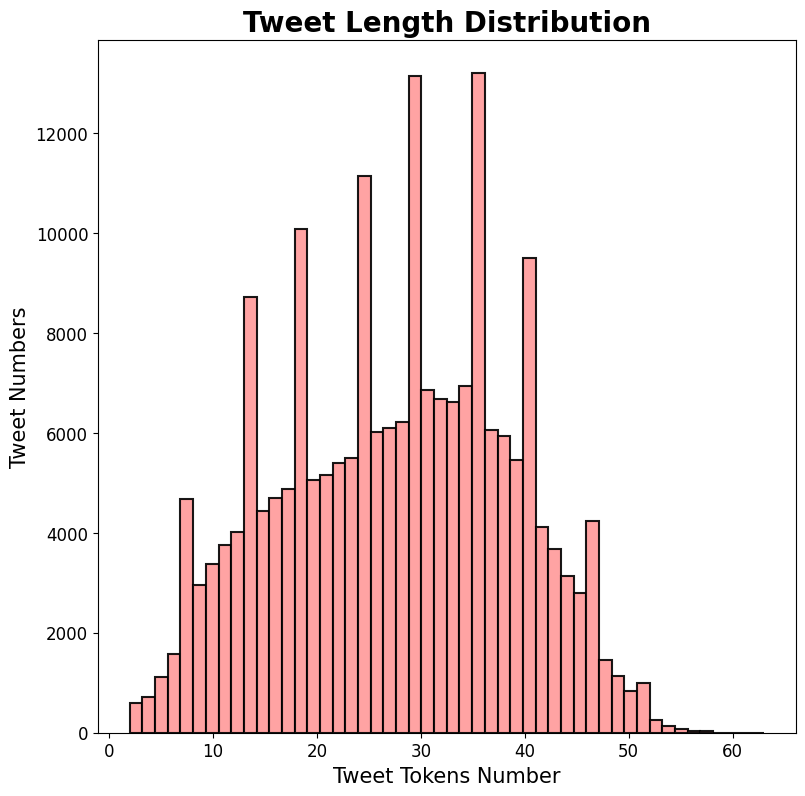

In [52]:
# tweetlerin token sayılarına göre dağılımı
plt.figure(figsize=(9,9))
plt.hist(df.token_numbers, bins=50, color='#ff9999', edgecolor='black', linewidth=1.5, alpha=0.9)
plt.xticks(fontsize=12), plt.yticks(fontsize=12), plt.xlabel('Tweet Tokens Number', fontsize=15), plt.ylabel('Tweet Numbers', fontsize=15),\
    plt.title('Tweet Length Distribution', fontsize=20, fontweight='bold')
plt.show()

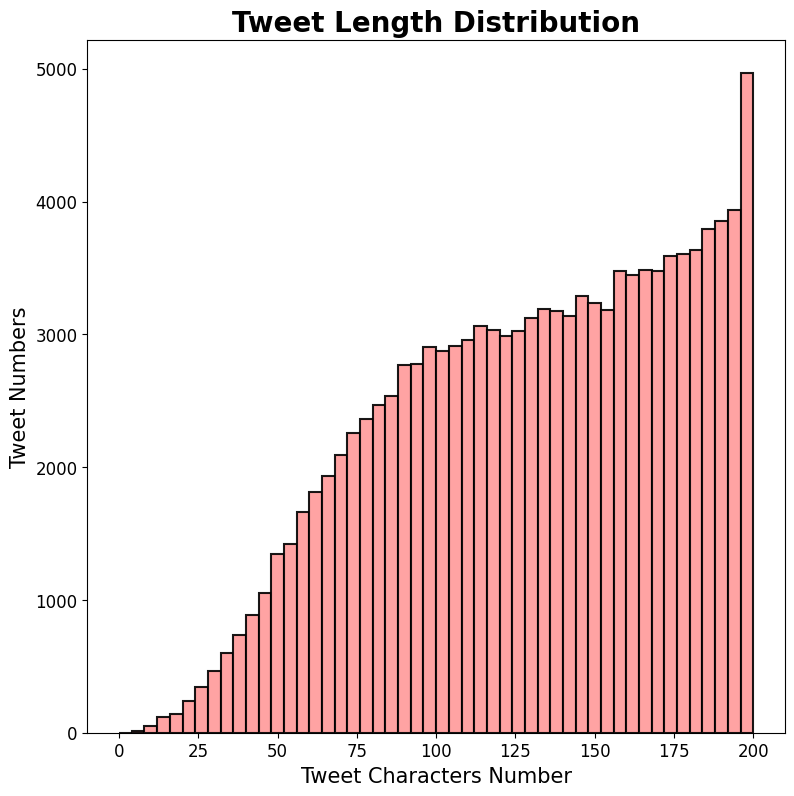

In [53]:
# tweetlerin karakter sayılarına göre dağılımı
plt.figure(figsize=(9,9))
plt.hist(df.char_numbers, bins=50, color='#ff9999', edgecolor='black', linewidth=1.5, alpha=0.9, range=(0,200))
plt.xticks(fontsize=12), plt.yticks(fontsize=12), plt.xlabel('Tweet Characters Number', fontsize=15), plt.ylabel('Tweet Numbers', fontsize=15),\
    plt.title('Tweet Length Distribution', fontsize=20, fontweight='bold')
plt.show()

In [54]:
df.char_numbers.describe()

count    209572.000000
mean        178.957714
std          66.847499
min           5.000000
25%         126.000000
50%         188.000000
75%         237.000000
max         288.000000
Name: char_numbers, dtype: float64

In [55]:
# tweetlerin karakter sayılarına göre aykırı değerlerin hesaplanması
Q1 = df.char_numbers.quantile(0.25)
Q3 = df.char_numbers.quantile(0.75)
IQR = Q3 - Q1
print('Q1 (%25): ', Q1)
print('Q3 (75) : ', Q3)




Q1 (%25):  126.0
Q3 (75) :  237.0


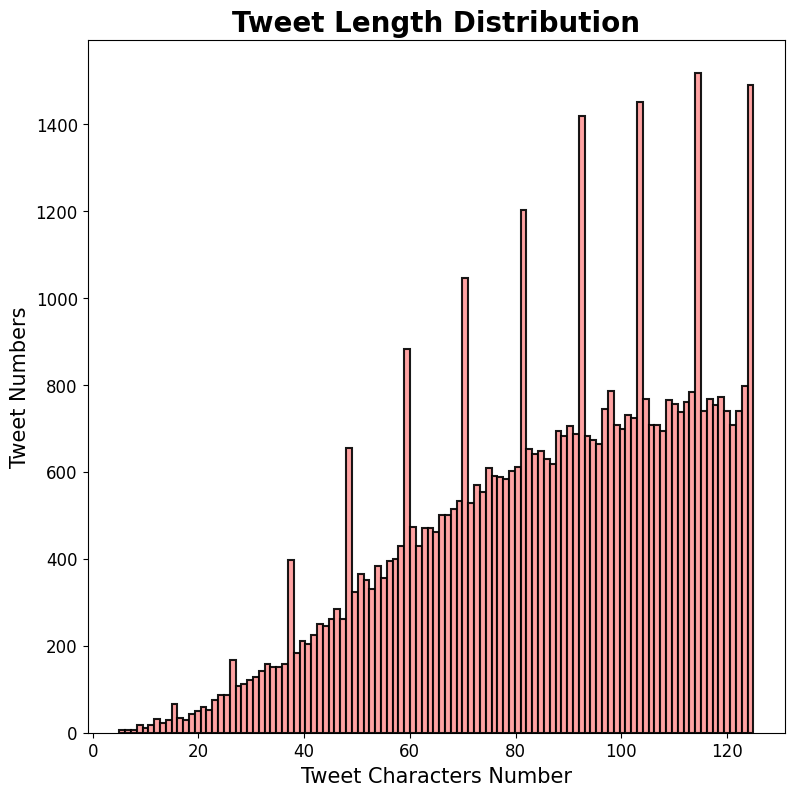

In [56]:
# Q1 (%25) altındaki değerler ve token sayılarının dağılımı
plt.figure(figsize=(9,9))
plt.hist(df[df['char_numbers']<Q1].char_numbers, bins=109, color='#ff9999', edgecolor='black', linewidth=1.5, alpha=0.9)
plt.xticks(fontsize=12), plt.yticks(fontsize=12), plt.xlabel('Tweet Characters Number', fontsize=15), plt.ylabel('Tweet Numbers', fontsize=15),\
    plt.title('Tweet Length Distribution', fontsize=20, fontweight='bold')
plt.show()


In [57]:
# Q1 değerinden daha az karakter sayısına sahip olan tweetlerin istatisliksel olarak incelenmesi
df[df['char_numbers'] < Q1]['char_numbers'].describe()


count    52303.000000
mean        86.410913
std         25.973725
min          5.000000
25%         68.000000
50%         90.000000
75%        108.000000
max        125.000000
Name: char_numbers, dtype: float64

In [58]:
df[df['char_numbers']>58].tweet.sample(10).values

array(['CELEBRATING THE TEAM QEH AWARDS 2022 Congratulations to Linda Purdy - Patient Safety Champion finalist. Her passion dedication and determination to ensure all patients receive the best experience is without a doubt something for us all to aspire to. #TeamQEHAwards2022',
       'Fabulous to have face to face training with Barbican #ANTT #InfectionPrevention #PatientSafety',
       'Absolutely Derek, I know that many trusts have done brilliant work in this area - but its the variation and lack of standardisation thats the problem. The new patient safety strategy will help hugely when its implemented -',
       'I honestly think the requirement of curriculums for medical students and doctors to learn drug doses is a patient safety issue. The risk:benefit is too great - it literally takes lt10 seconds to check a dose on the online BNF vs. potentially fatal overdose',
       'Compensation cases should be settled much faster in a climate of transparency - but there also needs to be p

In [59]:
# son olarak karakter sayısı 59 ve 59 dan fazla olan tweetleri corpusumuza dahil ediyoruz
df = df[df['char_numbers']>58]
df.shape

(200930, 14)

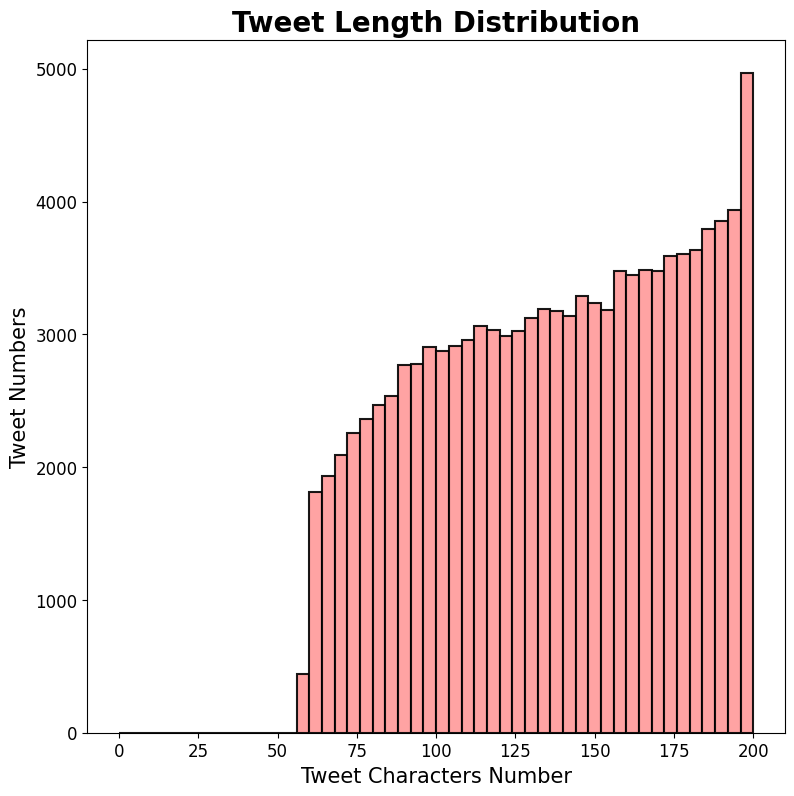

In [58]:
#karakter sayısına göre tweetlerin dağılımı
plt.figure(figsize=(9,9))
plt.hist(df.char_numbers, bins=50, color='#ff9999', edgecolor='black', linewidth=1.5, alpha=0.9, range=(0,200))
plt.xticks(fontsize=12), plt.yticks(fontsize=12), plt.xlabel('Tweet Characters Number', fontsize=15), plt.ylabel('Tweet Numbers', fontsize=15),\
    plt.title('Tweet Length Distribution', fontsize=20, fontweight='bold')
plt.show()

In [60]:
df.to_csv('cleaned_ps_corpus.csv', index=False)

In [7]:
df = pd.read_csv('cleaned_ps_corpus.csv')

In [11]:
import nltk
from nltk.corpus import stopwords

# stop words
stop_words = stopwords.words('english')

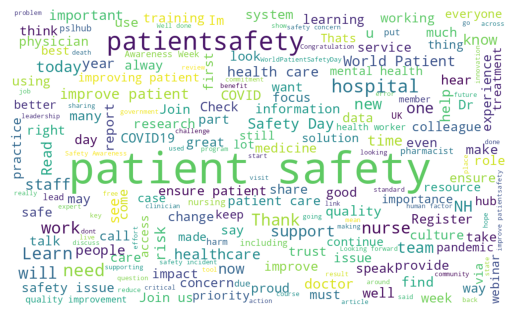

In [17]:
wc = WordCloud(width=1000, height=600, background_color="white")
plt.imshow(wc.generate(df.tweet.str.cat(sep=' ')))

plt.axis("off") 
plt.show()

image = wc.to_image()
image.show()